# 1. Import Libraries

In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

In [112]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import plotly.express as px
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.keras.layers import Dense, Flatten,  LSTM, GRU, LeakyReLU, Dropout, Bidirectional

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer, RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    BaggingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor, 
    HistGradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
)
from xgboost import XGBRegressor

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

from pycaret.regression import RegressionExperiment

from tqdm.notebook import tqdm
tqdm.pandas()


# 2. Load Data

In [83]:
data = pd.read_csv('../Dataset/world.csv', na_values='NaN')
data

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,West Bank,NEAR EAST,2460492,5860,"419,9","0,00","2,98","19,62",800.0,NaN,"145,2","16,9","18,97","64,13",3,"31,67","3,92","0,09","0,28","0,63"
223,Western Sahara,NORTHERN AFRICA,273008,266000,"1,0","0,42",NaN,NaN,NaN,NaN,NaN,"0,02",0,"99,98",1,NaN,NaN,NaN,NaN,"0,4"
224,Yemen,NEAR EAST,21456188,527970,"40,6","0,36",0,"61,5",800.0,"50,2","37,2","2,78","0,24","96,98",1,"42,89","8,3","0,135","0,472","0,393"
225,Zambia,SUB-SAHARAN AFRICA,11502010,752614,"15,3","0,00",0,"88,29",800.0,"80,6","8,2","7,08","0,03","92,9",2,41,"19,93","0,22","0,29","0,489"


# 3. Initial Analysis

### 3.1. Metadata

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Country                             227 non-null    object 
 1   Region                              227 non-null    object 
 2   Population                          227 non-null    int64  
 3   Area (sq. mi.)                      227 non-null    int64  
 4   Pop. Density (per sq. mi.)          227 non-null    float64
 5   Coastline (coast/area ratio)        227 non-null    float64
 6   Net migration                       227 non-null    float64
 7   Infant mortality (per 1000 births)  227 non-null    float64
 8   GDP ($ per capita)                  227 non-null    float64
 9   Literacy (%)                        227 non-null    float64
 10  Phones (per 1000)                   227 non-null    float64
 11  Arable (%)                          227 non-n

In [14]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Population,227.0,2.874028e+07,1.178913e+08,7026.0,437624.0,4786994.0,17497772.5,1.313974e+09
Area (sq. mi.),227.0,5.982270e+05,1.790282e+06,2.0,4647.5,86600.0,441811.0,1.707520e+07
GDP ($ per capita),227.0,9.689823e+03,1.002688e+04,500.0,1900.0,5600.0,15700.0,5.510000e+04


In [50]:
data.isnull().sum().sum()

0

In [42]:
print(f'Number of duplicates data : {data.duplicated().sum()}')

Number of duplicates data : 0


### 3.2. Columns Processing

In [93]:
numerical_columns = [column_name for column_name in data.columns if data[column_name].dtype != 'object']
categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object']
print(f'Numerical Columns   : {numerical_columns}')
print(f'Categorical Columns : {categorical_columns}')

Numerical Columns   : ['Region', 'Population', 'Area (sq. mi.)', 'Pop. Density (per sq. mi.)', 'Coastline (coast/area ratio)', 'Net migration', 'Infant mortality (per 1000 births)', 'GDP ($ per capita)', 'Literacy (%)', 'Phones (per 1000)', 'Arable (%)', 'Crops (%)', 'Other (%)', 'Climate', 'Birthrate', 'Deathrate', 'Agriculture', 'Industry', 'Service']
Categorical Columns : ['Country']


In [87]:
def string_to_numeric(data):
    to_numeric = ['Pop. Density (per sq. mi.)', 'Coastline (coast/area ratio)', 'Net migration', 'Infant mortality (per 1000 births)', 'Literacy (%)', 'Phones (per 1000)', 'Arable (%)', 'Crops (%)', 
                'Other (%)', 'Climate', 'Birthrate', 'Deathrate', 'Agriculture', 'Industry', 'Service']
    
    for colum in to_numeric:
        data[colum] = data[colum].str.replace(',', '.')
        data[colum] = pd.to_numeric(data[colum])
    return data

data = string_to_numeric(data)

In [68]:
data['Pop. Density (per sq. mi.)'] = data['Pop. Density (per sq. mi.)'].str.replace(',', '.')
data['Pop. Density (per sq. mi.)'] = pd.to_numeric(data['Pop. Density (per sq. mi.)'])

In [90]:
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].mean())
data[categorical_columns] = data[categorical_columns].fillna(data.mode().iloc[0])

In [92]:
def change_columns_to_numerical(data):
    LE = LabelEncoder()
    columns = ['Region']
    for column in columns:
        data[column] = LE.fit_transform(data[column].astype(str))
        data[column] = data[column].astype(int)
        print(f'{column} : {LE.classes_}') 
    return data

data = change_columns_to_numerical(data)

Region : ['ASIA (EX. NEAR EAST)         ' 'BALTICS                            '
 'C.W. OF IND. STATES ' 'EASTERN EUROPE                     '
 'LATIN AMER. & CARIB    ' 'NEAR EAST                          '
 'NORTHERN AFRICA                    '
 'NORTHERN AMERICA                   '
 'OCEANIA                            '
 'SUB-SAHARAN AFRICA                 '
 'WESTERN EUROPE                     ']


### 3.3. EDA

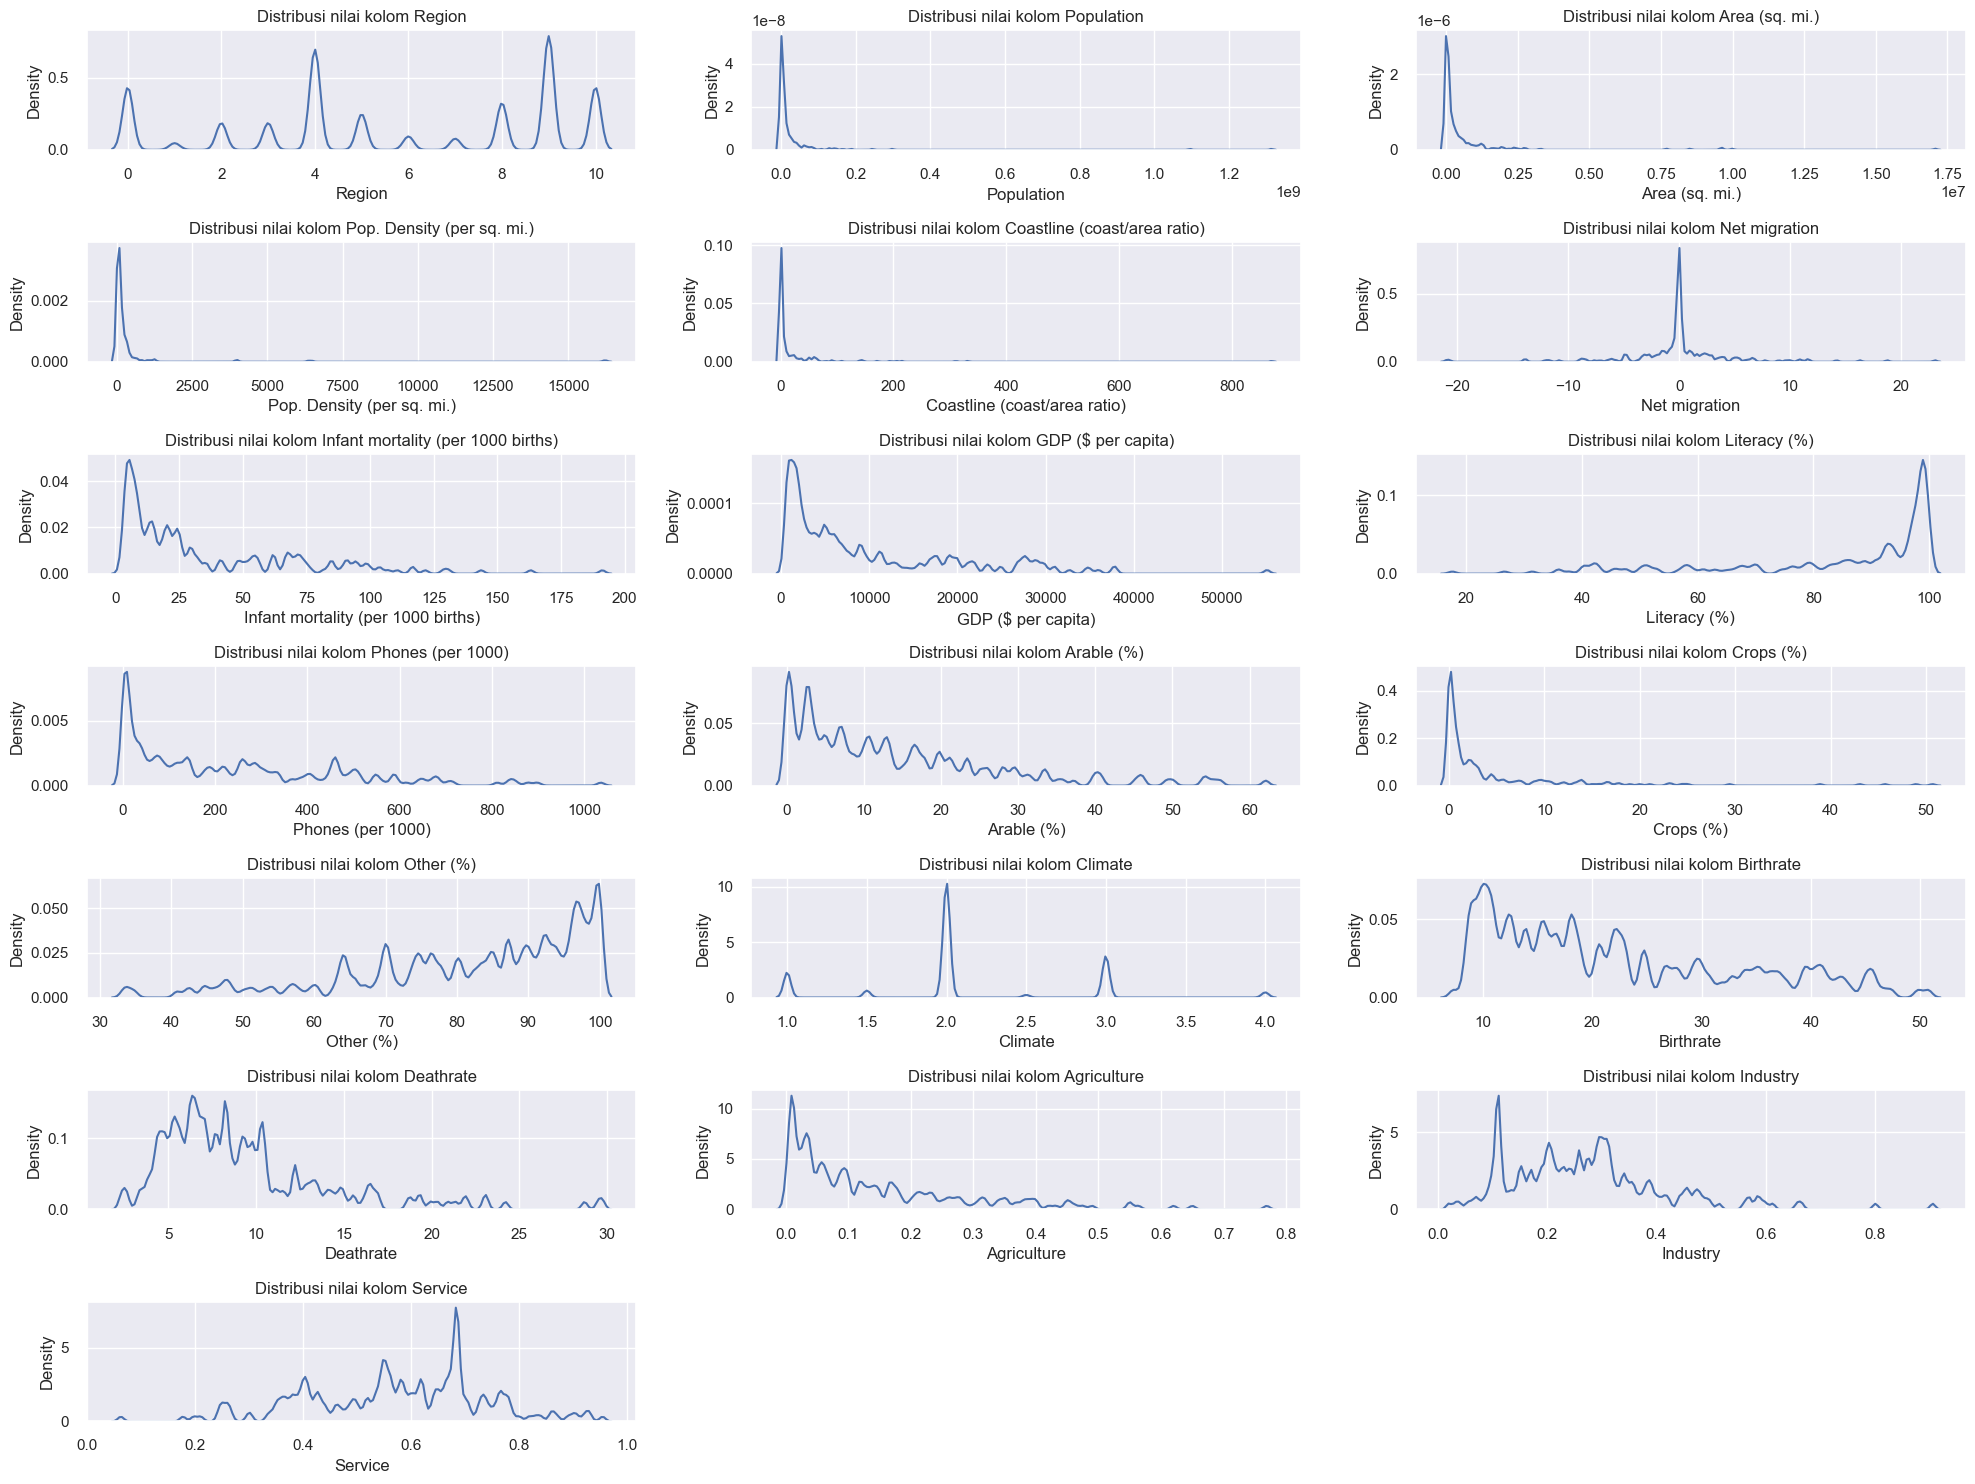

In [94]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data = data, x = column, ax=axes[row, col], bw_adjust=.1) \
        .set_title("Distribusi nilai kolom " + column)
    

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

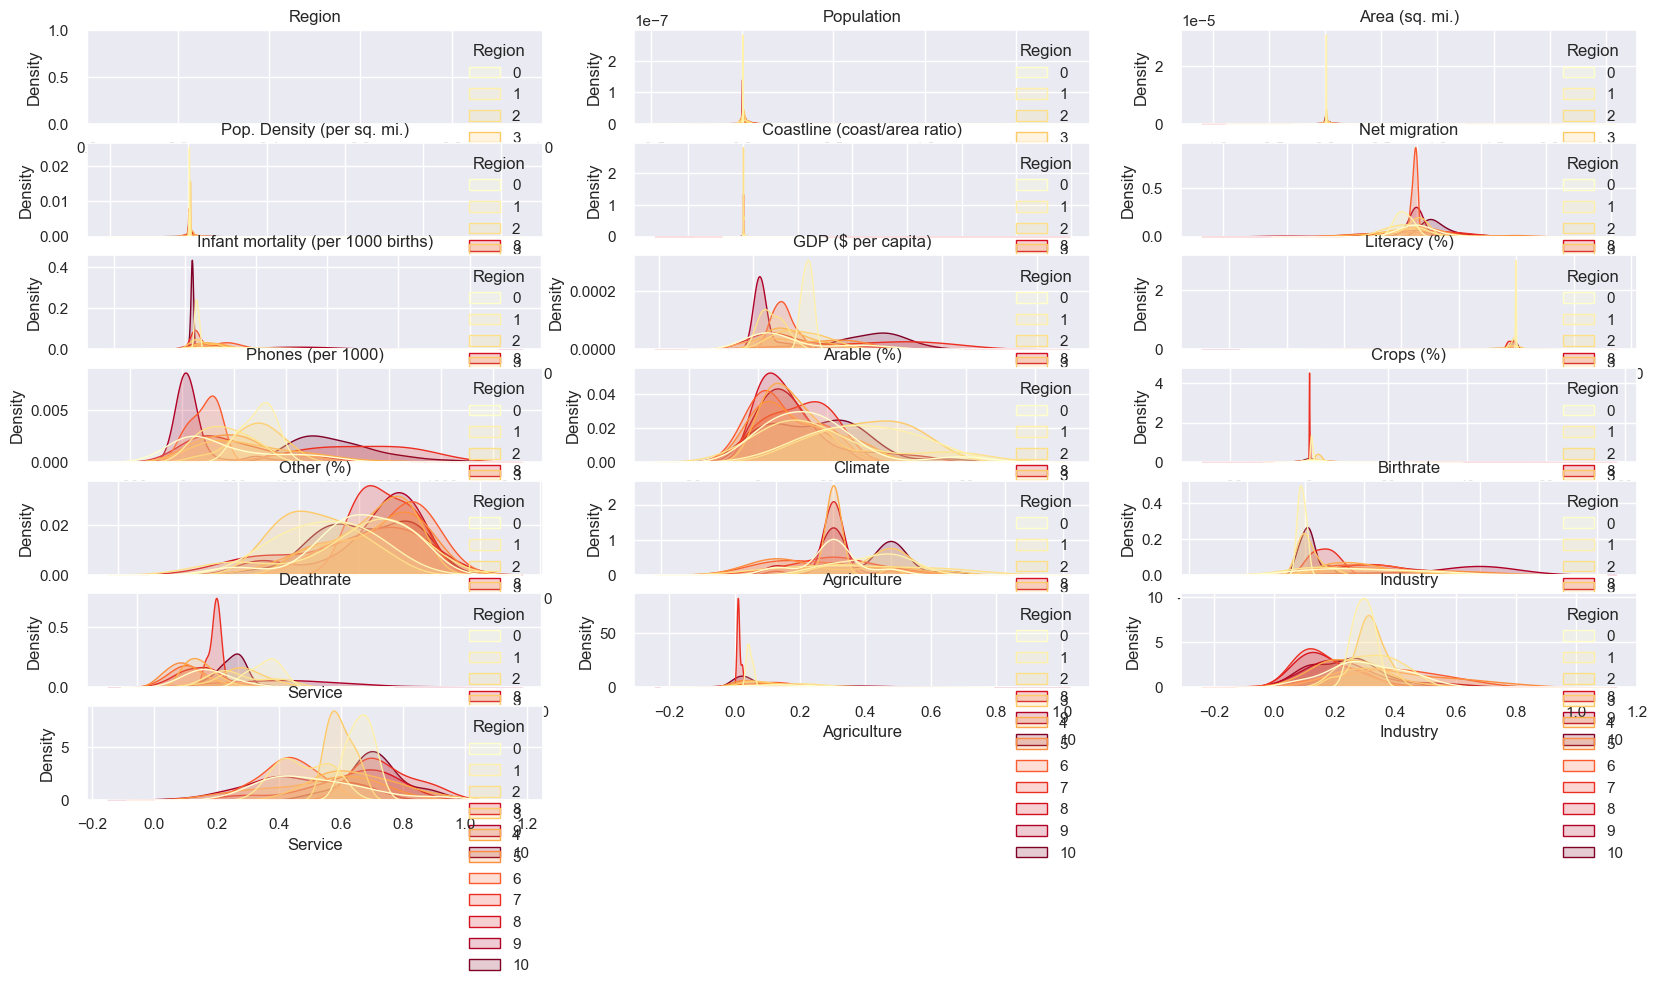

In [95]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data=data, x=column, hue="Region", 
                fill=True, alpha=.2, palette="YlOrRd", 
                common_norm=False, ax=axes[row, col],
                warn_singular=False)\
        .set_title(column)

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
sns.pairplot(data, diag_kind="kde")

In [ ]:
# plt.subplots(figsize = (20,4))
# ax = sns.countplot(data = data, x = 'cut', palette='YlOrBr')
# ax.bar_label(ax.containers[0])

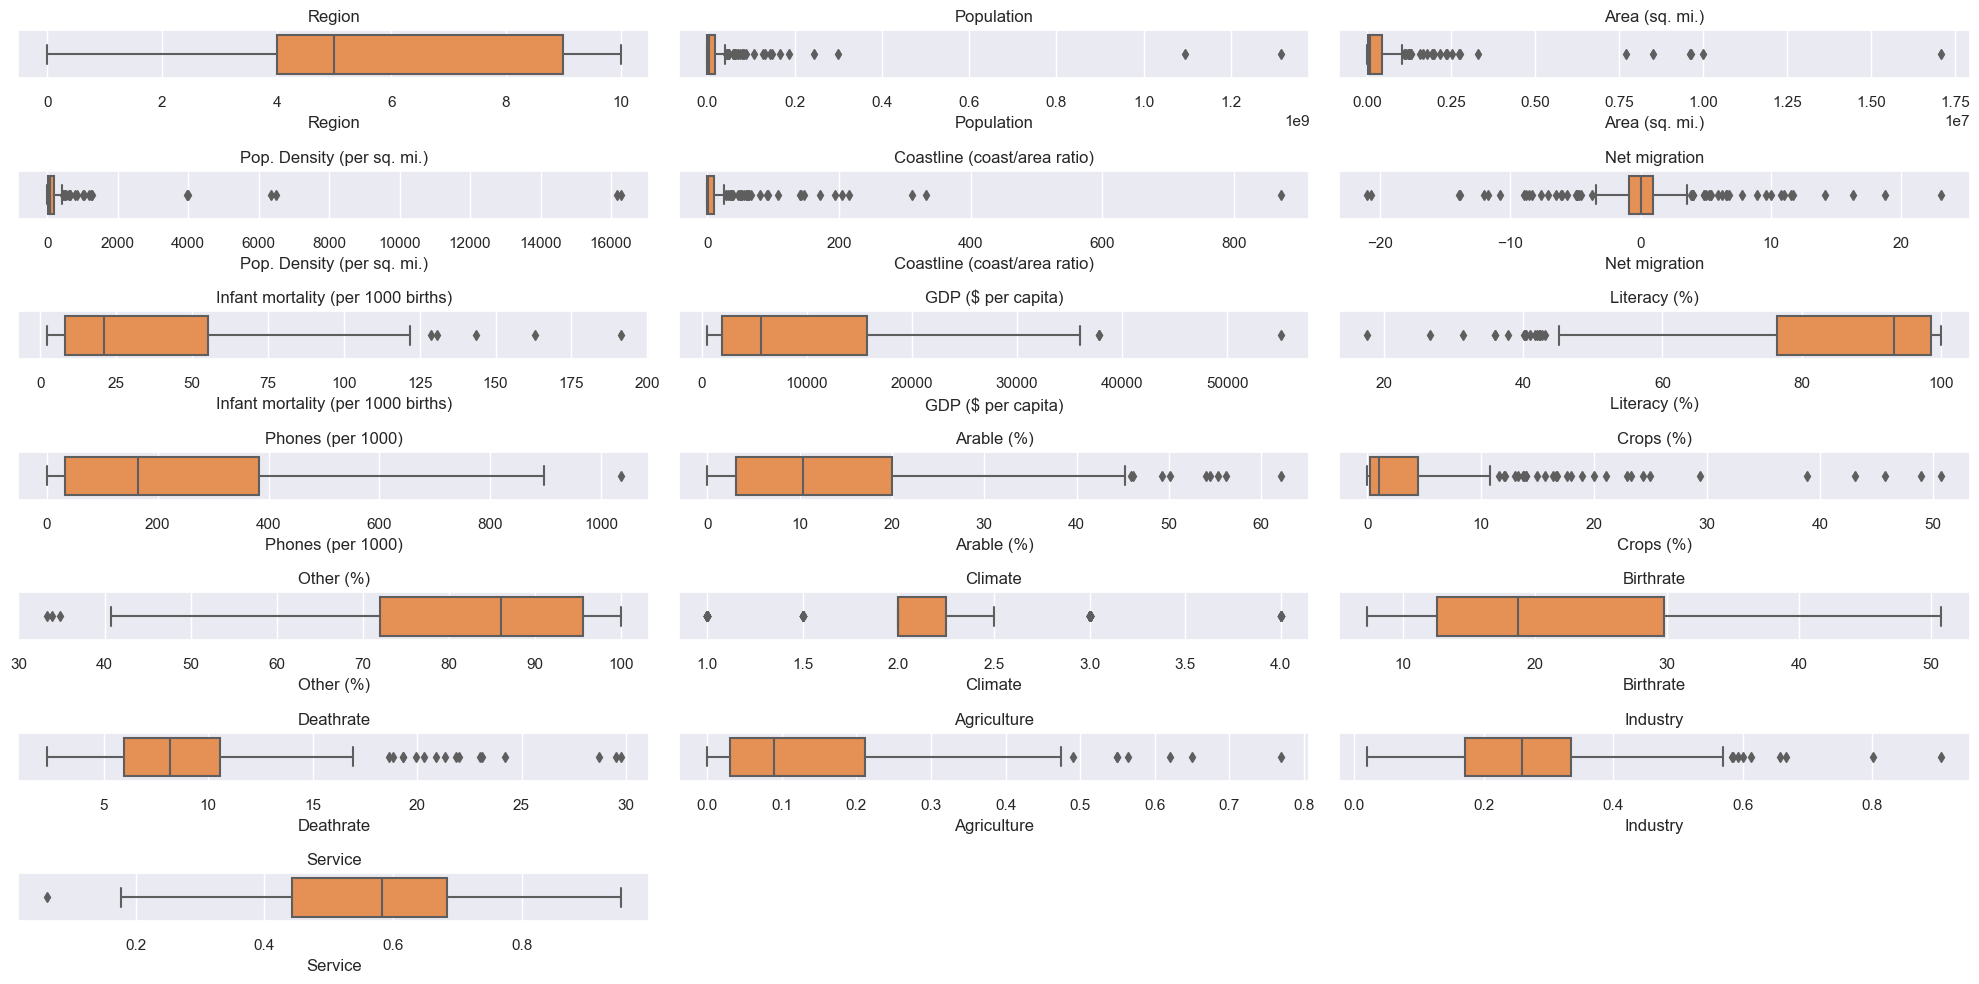

In [97]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=data[column], ax=axes[row, col], palette="Oranges").set_title(column)
    
for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [132]:
# Q1 = data['text_len'].quantile(0.25)
# Q3 = data['text_len'].quantile(1.)

# print(Q1)
# print(Q3)

# data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

# fig, axes = plt.subplots(figsize=(25, 2))
# sns.boxplot(x = data['text_len'], palette="Oranges")

# sns.stripplot(x=data['text_len'], data=data,
#               size=4, color=".3", linewidth=0, palette="crest", hue=data['text_len'])

### 3.4. Data Correlation

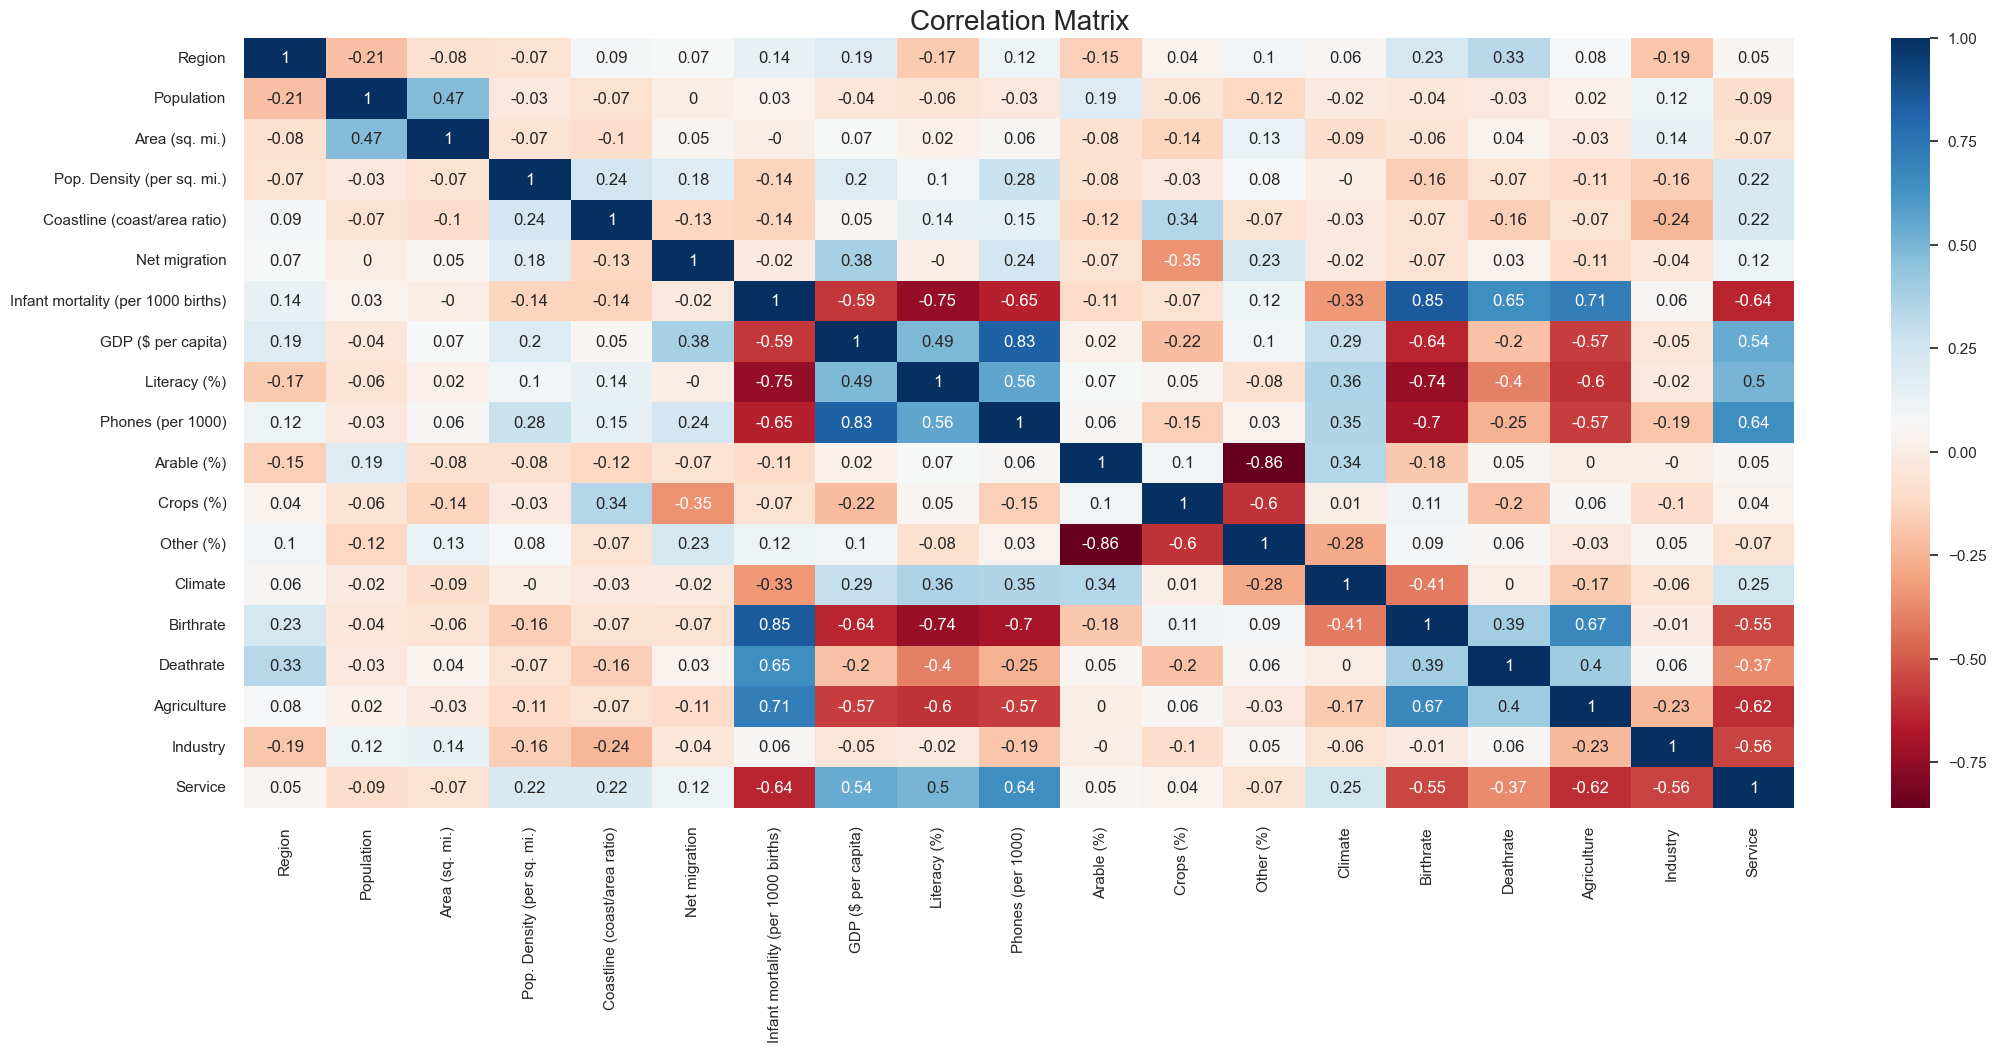

In [99]:
corr_data = data.corr().round(2)

mask = np.zeros_like(corr_data)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25, 10))
# sns.heatmap(corr_data, annot=True, mask=mask, cmap='RdBu')
sns.heatmap(corr_data, annot=True, cmap='RdBu')
plt.title("Correlation Matrix", size=20)
plt.show()

# 4. Data Preprocessing

### 4.1. Features Selections

In [266]:
### Pearson Correlation
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    print(str(len(cor_feature)), 'selected features')
    print(cor_feature)
    return cor_feature

### Chi-Squared
def chi_squared_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, Y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    print(str(len(chi_feature)), 'selected features')
    print(chi_feature)
    return chi_feature

### Recursive Feature Elimination
def recursive_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X_norm, Y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    print(rfe_feature)
    return rfe_feature

### Lasso: SelectFromModel
def lasso_elimination(X, Y, num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
    embeded_lr_selector.fit(X_norm, Y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    print(str(len(embeded_lr_feature)), 'selected features')
    print(embeded_lr_feature)
    return embeded_lr_feature

### LightGBM: SelectFromModel
def LGBMC_elimination(X, Y, num_feats):
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, Y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    print(str(len(embeded_lgb_feature)), 'selected features')
    print(embeded_lgb_feature)
    return embeded_lgb_feature

### Tree-based: SelectFromModel
def RFC_elimination (X, Y, num_feats):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, Y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features')
    print(embeded_rf_feature)
    return embeded_rf_feature

In [271]:
X = data.drop(columns=['Potability'])
Y = data['Potability']

num_feats = 10

selected_feature = cor_selector(X, Y,num_feats)
# selected_feature = chi_squared_elimination(X, Y,num_feats)
# selected_feature = recursive_elimination(X, Y,num_feats)
# selected_feature = lasso_elimination(X, Y, num_feats)
# selected_feature = LGBMC_elimination(X, Y, num_feats)
# selected_feature = RFC_elimination(X, Y, num_feats)

X = data[selected_feature]
Y = data['Credit_Score']


print(Counter(Y))
undersample = RandomUnderSampler()
X, Y = undersample.fit_resample(X, Y)
print(Counter(Y))

Y = to_categorical(Y)

scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

10 selected features
['Monthly_Balance', 'Num_Bank_Accounts', 'Credit_History_Age', 'Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date', 'Outstanding_Debt', 'Interest_Rate', 'Num_Credit_Inquiries', 'Credit_Mix']
Counter({0: 53174, 2: 28998, 1: 17828})
Counter({0: 17828, 1: 17828, 2: 17828})
(37545, 10)
(10590, 10)
(5349, 10)


### 4.2. Data Splitting

In [100]:
X = data.drop(columns=['Country', 'GDP ($ per capita)'])
Y = data['GDP ($ per capita)']

# print(Counter(Y))
# undersample = RandomUnderSampler()
# X, Y = undersample.fit_resample(X, Y)
# print(Counter(Y))

# scaler = MinMaxScaler(feature_range=(0,1))
scaler = RobustScaler()
X = scaler.fit_transform(X)
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(159, 18) (159,)
(45, 18) (45,)
(23, 18) (23,)


# 5. Neural Network Algoritms

In [130]:
def DNN_Model():
    model = Sequential()
    model.add(Dense(4096, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.01), input_shape=(X_train.shape[1],)))
    # model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
    # model.add(Dropout(0.5))
    model.add(Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
    # model.add(Dropout(0.5))
    model.add(Dense(1))
    
    return model

def LSTM_Model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    # model.add(LSTM(64))
    model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    return model

def GRU_Model():
    model = Sequential()
    model.add((GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1))))
    # model.add(GRU(64, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True))
    model.add((GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    # model.add(Dense(128, activation='relu'))
    # model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    return model

model = DNN_Model()
# model = LSTM_Model()
# model = GRU_Model()

model.summary()

# opt = SGD(learning_rate=0.01, momentum=0.9)
opt = Adam(learning_rate = 0.000_1)

model.compile(loss='mse', optimizer=opt, metrics=['mse'])
# model.compile(loss='mae', optimizer = opt, metrics=['mae'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 4096)              77824     
                                                                 
 dense_21 (Dense)            (None, 4096)              16781312  
                                                                 
 dense_22 (Dense)            (None, 1000)              4097000   
                                                                 
 dense_23 (Dense)            (None, 1)                 1001      
                                                                 
Total params: 20,957,137
Trainable params: 20,957,137
Non-trainable params: 0
_________________________________________________________________


In [131]:
num_epoch = 1000
batch_size = 32

history = model.fit(X_train, y_train, verbose=2,
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (X_val, y_val))

Epoch 1/1000
5/5 - 1s - loss: 198626320.0000 - mse: 198626272.0000 - val_loss: 129632376.0000 - val_mse: 129632320.0000 - 595ms/epoch - 119ms/step
Epoch 2/1000
5/5 - 0s - loss: 198544848.0000 - mse: 198544736.0000 - val_loss: 129525384.0000 - val_mse: 129525328.0000 - 84ms/epoch - 17ms/step
Epoch 3/1000
5/5 - 0s - loss: 198378032.0000 - mse: 198377984.0000 - val_loss: 129328952.0000 - val_mse: 129328896.0000 - 82ms/epoch - 16ms/step
Epoch 4/1000
5/5 - 0s - loss: 198087760.0000 - mse: 198087680.0000 - val_loss: 129002152.0000 - val_mse: 129002096.0000 - 80ms/epoch - 16ms/step
Epoch 5/1000
5/5 - 0s - loss: 197599616.0000 - mse: 197599552.0000 - val_loss: 128502576.0000 - val_mse: 128502520.0000 - 83ms/epoch - 17ms/step
Epoch 6/1000
5/5 - 0s - loss: 196932336.0000 - mse: 196932272.0000 - val_loss: 127765808.0000 - val_mse: 127765752.0000 - 80ms/epoch - 16ms/step
Epoch 7/1000
5/5 - 0s - loss: 195915808.0000 - mse: 195915744.0000 - val_loss: 126733008.0000 - val_mse: 126732952.0000 - 82ms/e

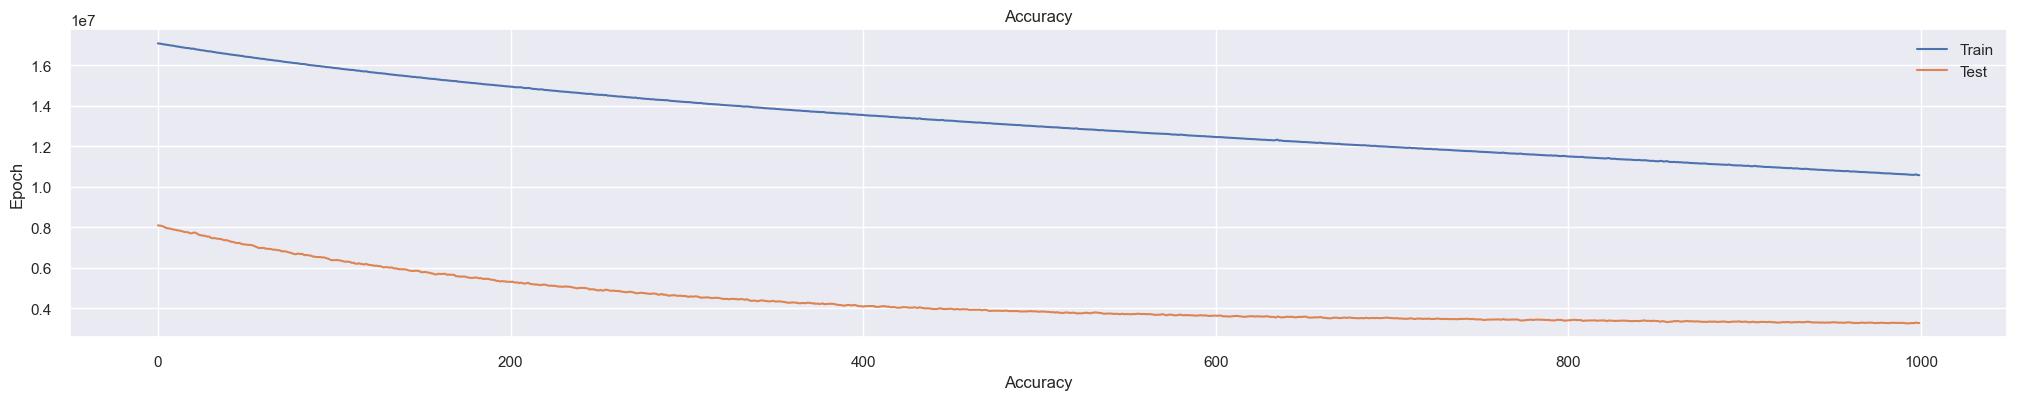

In [128]:
fig, ax = plt.subplots(figsize=(25, 4))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Accuracy')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [107]:
y_pred = model.predict(X_test, verbose = 0)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))
print("Mean Absolute Error:",round(mean_absolute_error(y_test, y_pred), 2))


R Squared Error    : 0.74
Mean Squared Error : 22638521.06
Mean Absolute Error: 3403.83


In [108]:
train_predictions = np.rint(model.predict(X_test, verbose=0)).astype(int).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print((train_results['Diff'].mean()), '/', (train_results['Diff'].sum()))
print((train_results['Diff'].max()))


     Train Predictions  Actuals    Diff
146              29643  28600.0  1043.0
79               21847  20000.0  1847.0
44                2024    700.0  1324.0
46                3373    700.0  2673.0
41               12890   9900.0  2990.0
3403.8 / 153171.0
10785.0


In [15]:
data_x = data.drop(columns=['Name', 'Overall'])

scaler = RobustScaler()
data_x = scaler.fit_transform(data_x)
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
data_x = scaler.fit_transform(data_x)

predictions = np.rint(model.predict(data_x, verbose=0)).astype(int).flatten()

data['Overall Prediction'] = pd.DataFrame(predictions)
data

,Name,Age,Nationality,Overall,Potential,Club,Preferred Foot,International Reputation,Weak Foot,Skill Moves,...,GKReflexes,Defending,General,Mental,Passing,Mobility,Power,Shooting,Rating,Overall Prediction
0,L. Messi,31,6,94,94,212,0,5.0,4.0,4.0,...,8.0,29,89,71,87,91,74,88,94,95
1,Cristiano Ronaldo,33,123,94,94,326,1,5.0,4.0,5.0,...,11.0,27,88,73,81,91,83,88,94,95
2,Neymar Jr,26,20,92,93,436,1,5.0,5.0,5.0,...,11.0,28,85,72,80,94,69,84,92,92
3,De Gea,27,139,91,93,375,1,4.0,3.0,1.0,...,94.0,16,26,43,39,66,54,21,92,90
4,K. De Bruyne,27,13,91,92,374,1,4.0,5.0,4.0,...,13.0,59,79,81,92,81,76,85,92,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,J. Lundstram,19,46,47,65,165,1,1.0,2.0,2.0,...,9.0,45,39,46,43,55,54,37,56,47
18203,N. Christoffersson,19,144,47,63,588,1,1.0,2.0,2.0,...,12.0,19,41,37,30,40,52,39,55,47
18204,B. Worman,16,46,47,67,122,1,1.0,3.0,2.0,...,13.0,19,43,36,30,59,51,42,57,47
18205,D. Walker-Rice,17,46,47,66,587,1,1.0,3.0,2.0,...,9.0,24,44,38,39,48,50,45,56,48


# 6. Supervised Learning

### 6.1. Stacking Algoritms

In [114]:
adaboost = AdaBoostRegressor(n_estimators = 100, random_state = 42)
bagging = BaggingRegressor(n_jobs = -1)
extraTrees = ExtraTreesRegressor(max_depth = 100, n_jobs = -1, random_state = 42)
gradient = GradientBoostingRegressor(max_depth = 100, n_estimators = 100, learning_rate = .01,  random_state = 0)
randomForest = RandomForestRegressor(max_depth = 100, random_state = 42, n_jobs = -1)
histGradient = HistGradientBoostingRegressor()
XGB = XGBRegressor(n_jobs = -1)
knn = KNeighborsRegressor(n_jobs = -1)
decisionTree = DecisionTreeRegressor( max_depth = 100, random_state = 42)
linear = LinearRegression()

model = StackingRegressor([
    ('extraTrees', extraTrees),
    ('histGradient', histGradient),
    ('adaboost', adaboost),
    ('bagging', bagging),
    ('randomforest', randomForest),
    ('XGB', XGB),
    ('decisionTree', decisionTree),
    ('linear', linear),
    # ('gradient', gradient),
    # ('knn', knn),
], n_jobs=-1)

In [115]:
model.fit(X_train, y_train)

StackingRegressor(estimators=[('extraTrees',
                               ExtraTreesRegressor(max_depth=100, n_jobs=-1,
                                                   random_state=42)),
                              ('histGradient', HistGradientBoostingRegressor()),
                              ('adaboost',
                               AdaBoostRegressor(n_estimators=100,
                                                 random_state=42)),
                              ('bagging', BaggingRegressor(n_jobs=-1)),
                              ('randomforest',
                               RandomForestRegressor(max_depth=100, n_jobs=-1,
                                                     random_state=42)),
                              ('XGB',
                               XGB...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                              ('decisionTree',
                               DecisionTreeRegressor(max_depth=100,
                                                     random_state=42)),
                              ('linear', LinearRegression())],
                  n_jobs=-1)

In [116]:
print("Train Score        :",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score         :",round((model.score(X_test, y_test)*100), 2),'%')

y_pred = model.predict(X_test)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))
print("Mean Absolute Error:",round(mean_absolute_error(y_test, y_pred), 2))

Train Score        : 99.16 %
Test Score         : 80.22 %
R Squared Error    : 0.8
Mean Squared Error : 16968379.99
Mean Absolute Error: 2816.84


In [121]:
train_predictions = np.rint(model.predict(X_test)).astype(int).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test.astype(int)})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print((train_results['Diff'].mean()), '/', (train_results['Diff'].sum()))
print((train_results['Diff'].max()))


     Train Predictions  Actuals  Diff
146              27349    28600  1251
79               27299    20000  7299
44                1293      700   593
46                2534      700  1834
41               10554     9900   654
2816.8444444444444 / 126758
11214


In [60]:
data_x = data.drop(columns=['Name', 'Overall'])

scaler = RobustScaler()
data_x = scaler.fit_transform(data_x)
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
data_x = scaler.fit_transform(data_x)

predictions = np.rint(model.predict(data_x)).astype(int).flatten()

data['Overall Prediction'] = pd.DataFrame(predictions)
data

,Name,Age,Nationality,Overall,Potential,Club,Preferred Foot,International Reputation,Weak Foot,Skill Moves,...,GKReflexes,Defending,General,Mental,Passing,Mobility,Power,Shooting,Rating,Overall Prediction
0,L. Messi,31,6,94,94,212,0,5.0,4.0,4.0,...,8.0,29,89,71,87,91,74,88,94,94
1,Cristiano Ronaldo,33,123,94,94,326,1,5.0,4.0,5.0,...,11.0,27,88,73,81,91,83,88,94,94
2,Neymar Jr,26,20,92,93,436,1,5.0,5.0,5.0,...,11.0,28,85,72,80,94,69,84,92,92
3,De Gea,27,139,91,93,375,1,4.0,3.0,1.0,...,94.0,16,26,43,39,66,54,21,92,89
4,K. De Bruyne,27,13,91,92,374,1,4.0,5.0,4.0,...,13.0,59,79,81,92,81,76,85,92,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,J. Lundstram,19,46,47,65,165,1,1.0,2.0,2.0,...,9.0,45,39,46,43,55,54,37,56,47
18203,N. Christoffersson,19,144,47,63,588,1,1.0,2.0,2.0,...,12.0,19,41,37,30,40,52,39,55,47
18204,B. Worman,16,46,47,67,122,1,1.0,3.0,2.0,...,13.0,19,43,36,30,59,51,42,57,47
18205,D. Walker-Rice,17,46,47,66,587,1,1.0,3.0,2.0,...,9.0,24,44,38,39,48,50,45,56,48


### 6.2. Pycarets

In [13]:
s = RegressionExperiment()
s.setup(data, target = 'price', session_id = 123)

In [14]:
best = s.compare_models()
print(best)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:24:29
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


In [ ]:
s.evaluate_model(best)

In [16]:
s.predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,284.1660,292688.2905,541.0067,0.9817,0.1070,0.0831


,carat,cut,color,clarity,depth,table,x,y,z,price,prediction_label
47295,0.30,1,2,3,63.400002,56.0,4.26,4.29,2.71,394,486.420649
52309,0.31,2,0,2,62.299999,56.0,4.32,4.35,2.70,548,682.183706
3825,0.73,2,1,4,61.400002,55.0,5.80,5.82,3.57,3471,3510.702591
45257,0.51,2,2,5,61.599998,57.0,5.14,5.15,3.17,1661,1652.668495
8585,1.01,4,5,5,61.299999,56.0,6.53,6.45,3.98,4438,4476.470241
...,...,...,...,...,...,...,...,...,...,...,...
13768,1.35,4,6,2,61.099998,61.0,7.10,7.13,4.35,5613,5533.372564
46340,0.50,1,0,5,63.700001,56.0,5.09,5.05,3.23,1758,1613.025171
47227,0.60,2,0,2,62.299999,57.0,5.42,5.37,3.36,1840,1804.547772
22661,1.26,2,2,5,61.500000,56.0,6.97,7.01,4.30,10709,9923.811775
